## Ex 3.1 Hough Transform  (4 p)

Detect edges in the image 'Corridor1.jpg' using OpenCV's Canny edge detector (cv2.Canny).
After finding possible edges, implement yourself a Hough line detector based on the
method presented at the lectures. Use the Hough line detector to detect lines in the given image and visualize your computed lines using Matplotlib.

Your implementation of the Hough line detector should be based on Numpy arrays and not use the OpenCV function for Houghlines. For validation purpose only, you may use OpenCV's built-in functions for computing Hough lines (cv2.HoughLines) to compare its results to yours. 

In [1]:
#imports
import cv2
import numpy as np
from matplotlib import pyplot as plt

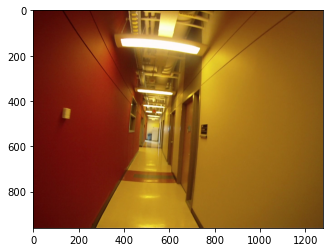

In [2]:
#reading and plotting image
image = cv2.imread("Corridor1.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure()
plt.imshow(image)
plt.show()

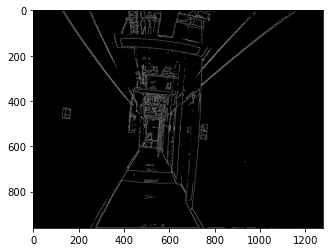

In [432]:
#edge detection
#changing the sensitivity changes the threshold for edges to be shown
sensitivity = 70
edge_image = cv2.Canny(image, sensitivity, sensitivity) #prev 70,70
plt.imshow(edge_image, cmap="gray")

In [428]:
#hough line detection
height, width = edge_image.shape[:2]

#increasing num_rhos leads to higher runtime but better results
num_rhos = 500
num_thetas = 180

diagonal = np.sqrt(np.square(height) + np.square(width))
dtheta = 180 / num_thetas
drho = (2 * diagonal) / num_rhos

thetas = np.arange(0, 180, step=dtheta)
rhos = np.arange(-diagonal, diagonal, step=drho)

cos_thetas = np.cos(np.deg2rad(thetas))
sin_thetas = np.sin(np.deg2rad(thetas))
accumulator = np.zeros((len(rhos), len(thetas)))

In [429]:
#collect votes for accumulator
for y in range(height):
    for x in range(width):
        if edge_image[y][x] != 0: #edge detected
            for theta_idx in range(len(thetas)):
                rho = ((x - width/2) * cos_thetas[theta_idx]) + ((y - height/2) * sin_thetas[theta_idx])
                theta = thetas[theta_idx]
                
                #find nearest rho value and vote
                rho_idx = np.argmin(np.abs(rhos - rho))
                accumulator[rho_idx][theta_idx] += 1

In [430]:
#filter out the edges with the most votes and display
def display_lines(bin_threshold=800):
    output_img = image.copy()

    for y in range(accumulator.shape[0]):
        for x in range(accumulator.shape[1]):
            if accumulator[y][x] > bin_threshold:
                rho = rhos[y]
                theta = thetas[x]

                # a and b correspond to x and y intercepts
                a = np.cos(np.deg2rad(theta))
                b = np.sin(np.deg2rad(theta))
                x0 = (a * rho) + width/2
                y0 = (b * rho) + height/2

                # extreme points for line drawing
                x1 = int(x0 + 1000 * (-b))
                y1 = int(y0 + 1000 * (a))
                x2 = int(x0 - 1000 * (-b))
                y2 = int(y0 - 1000 * (a))
                output_img = cv2.line(output_img, (x1,y1), (x2,y2), (0,255,0), 2)

    plt.figure(figsize=(10, 10))
    plt.title(f"Hough line detection with threshold={bin_threshold}")
    plt.imshow(output_img)

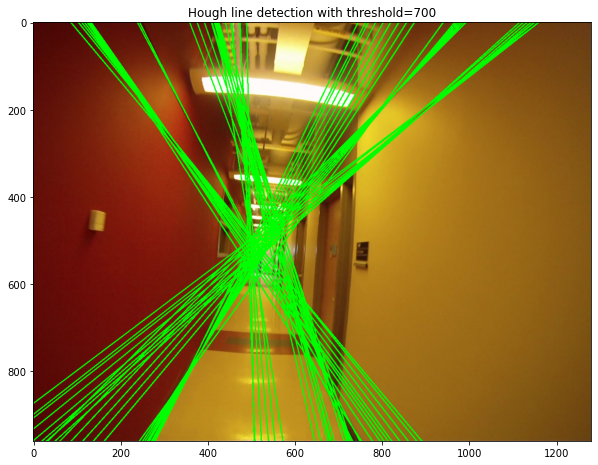

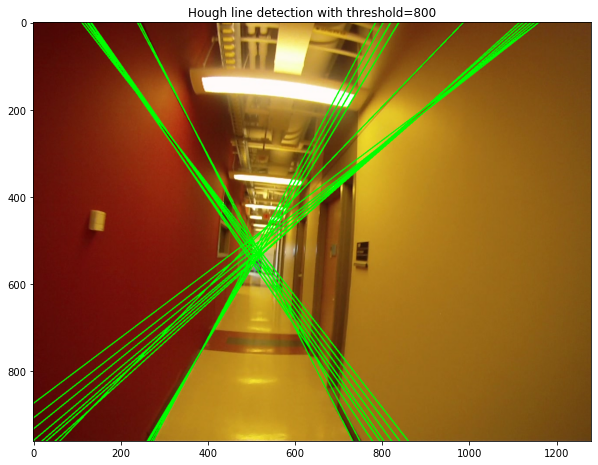

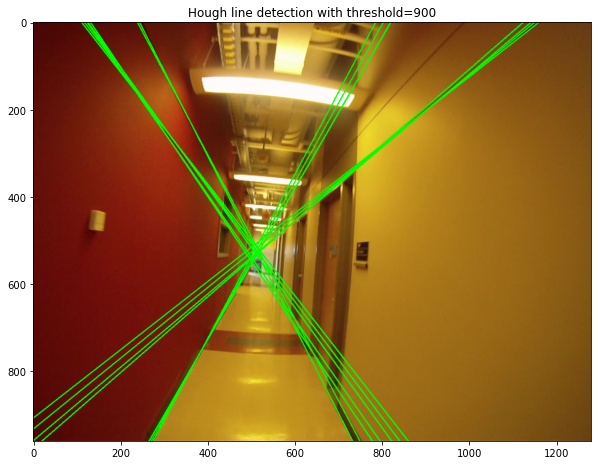

In [431]:
display_lines(700)
display_lines(800)
display_lines(900)

## Ex 3.2 Direct Linear Transformation (4 p)

Implement the normalized DLT (Direct Linear Transformation) algorithm
1) Take two images e.g. with your smartphone while rotating the phone a few degrees in between.

2) Detect features from those images using OpenCv's SIFT detector and OpenCV's BFFMatcher (https://docs.opencv.org/3.4/da/df5/tutorial_py_sift_intro.html and https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html)

3) Compute the 3x3 homography matrix H procedure such that xi’=Hxi (in homogenous coordinates) using DLT and at least 4-point correspondences.

To get improved performance normalize the points using the following algorithm:
- Normalize points xi: First move their average to (0,0) by substracting their mean. Then scale them to average length of 2 . The final transformation is: T= Tscale*Ttranslate 

- Do the same to points xi’, and obtain the transformation T’ For each correspondence xi ↔xi’ compute the matrix Ai (using the transformed points); see explanation and definitions from lecture slides. Assemble the n 2x9 matrices Ai into a single 2nx9 matrix A. Obtain the SVD of A. Here you can use Numpys SVD function. The unit singular vector corresponding to the smallest singular value is the solution h. Specifically, if A=UDVT with D diagonal with positive diagonal entries, arranged in descending order down the diagonal, then h is the last column of V. Denormalize the solution: inv(T’)*H*T.

(“Multiple View Geometry in computer vision”, by R. Hartley and A. Zisserman, p. 92)

In [484]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt

In [506]:
#read in images
img1_path = "img1.jpg" 
img2_path = "img2.jpg"
I1 = cv2.imread(img1_path)
I1 = cv2.cvtColor(I1, cv2.COLOR_BGR2GRAY)
I2 = cv2.imread(img2_path)
I2 = cv2.cvtColor(I2, cv2.COLOR_BGR2GRAY)

In [507]:
# Initiate ORB detector
orb = cv.ORB_create()
# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

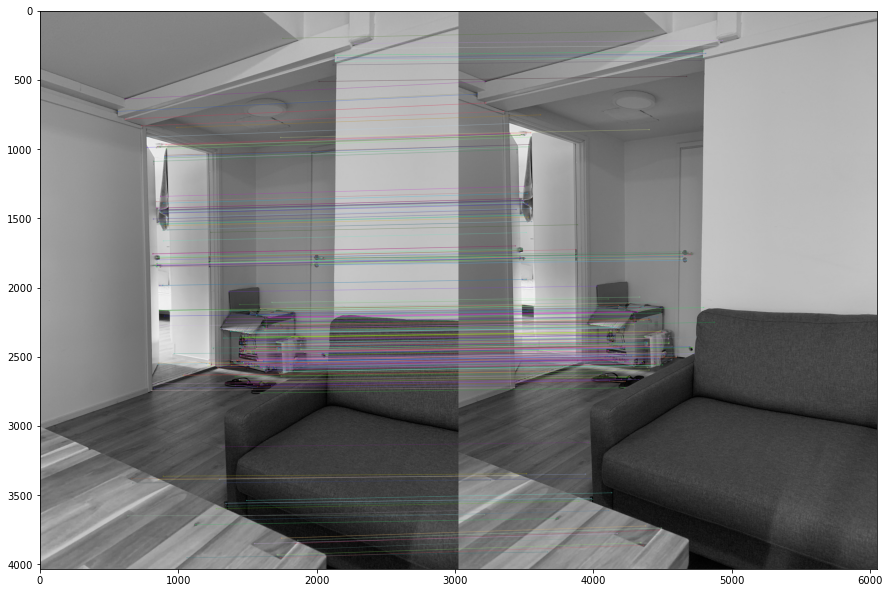

In [508]:
# create BFMatcher object
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
# Match descriptors.
matches = bf.match(des1,des2)
# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

In [509]:
#extracting 2 sets of points from cv2's matches
points1 = []
points2 = []

for dmatch in good:
    i1 = dmatch[0].queryIdx
    i2 = dmatch[0].trainIdx
    (x1, y1) = kp1[i1].pt
    (x2, y2) = kp2[i2].pt
    points1.append([x1, y1])
    points2.append([x2, y2])
    
points1 = np.array(points1)
points2 = np.array(points2)

In [510]:
#Takes in 2d points in homogeneous coordinates and returns normalized coordinates and the normalization matrix
def normalize(points):
    norm_pts = []
    xb = np.mean([p[0] for p in points]) #mean xs and ys
    yb = np.mean([p[1] for p in points])
    
    #calculate average distance between all points and mean, used for constructing T
    d = [np.sqrt(np.square(x - xb) + np.square(y - yb)) for x,y in points]
    d = np.mean(d)
    rt = 2 * np.sqrt(2)
    
    #transformation matrix T
    T = np.array([[rt/d, 0, (-rt*xb)/d],
                  [0, rt/d, (-rt*yb)/d],
                  [0, 0, 1]])
    
    #generate new points by multiplying by T
    for x, y in points:
        xi = np.array([x, y, 1])
        new_pt = xi @ T
        norm_pts.append(new_pt[:2])
    
    norm_pts = np.array(norm_pts)
    return norm_pts, T

In [511]:
#apply normalizing function
source, T = normalize(points1)
target, T_prime = normalize(points2)

In [512]:
#build A matrix according to the slides
def construct_A(source, target):
    x, y = source
    xp, yp = target

    #2x9 matrix component of A
    A_component = np.array([
        [-x, -y, -1, 0, 0, 0, x*xp, y*xp, xp],
        [0, 0, 0, -x, -y, -1, x*yp, y*yp, yp]
    ])
    return A_component

num_points = points_source.shape[0]

matrices = []
for i in range(num_points):
    partial_A = construct_A(source[i], target[i])
    matrices.append(partial_A)
    
#merge all components to create A
A = np.concatenate(matrices, axis=0)

In [513]:
#compute svd
u,s,v =np.linalg.svd(A, full_matrices=True)
H = v[-1].reshape(3,3)

In [514]:
#denormalize solution
#H = inv(T’)HT
H = np.linalg.inv(T_prime) @ H @ T
H = H/H[2,2]

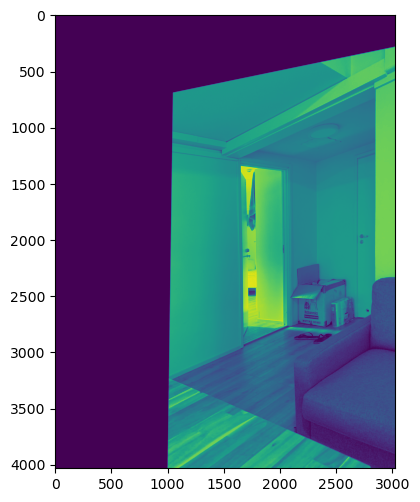

In [515]:
#use cv2.warpPerspective to visualize the homography matrix H
im_dst = cv2.warpPerspective(I1, np.linalg.inv(H), (I1.shape[1],I1.shape[0]))
plt.figure(figsize=(16, 6), dpi=100)
plt.imshow(im_dst)